In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.io as io
import os

### Direction vector 구하기

#### Method 1 : Mean

In [2]:
# Three points as (x, y, z) tuples
points = np.array([[1, 2, 3], [2, 4, 5], [3, 5, 7]])

# Calculate the average of the last two points
average_point = np.mean(points[1:], axis=0)

# Calculate the direction vector
direction_vector = average_point - points[0]

# Normalize the direction vector
normalized_direction = direction_vector / np.linalg.norm(direction_vector)

print("Normalized direction vector:", normalized_direction)

Normalized direction vector: [0.35856858 0.5976143  0.71713717]


#### Method 2 : Optimization

In [3]:
def distance(p, q, dir_vec):
    """
        p : point on the line
        q : 3d point
    
    """
    cross = torch.cross(q - p, dir_vec, dim = 0)
    distance = torch.norm(cross, p = 2, dim = 0) / torch.norm(dir_vec, p = 2, dim = 0)
    
    return distance

In [4]:
initial_point_value = torch.tensor([1., 2., 3])
initial_dir_value = torch.tensor([1.5, 1., 0.8])

initial_value = torch.hstack((initial_point_value,initial_dir_value))

opt_param = torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= "cuda")

# loss ftn
loss = 0
losses = []

lr = 1e-3 # 1e-3
decay_step = 2500 # 1000
epoch = 15000

num_pts = 3
points = torch.tensor([[1, 2, 3], [2, 4, 5], [3, 5, 7]], device = "cuda")

optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = 0.8)

for i in range(epoch):
    loss = 0
    # distance between 3 points
    for k in range(3):
        dist = distance(opt_param[:3], points[k], opt_param[3:]) # p, q, dir
        loss += dist

    optimizer.zero_grad()
    loss.backward()
    
    losses.append(loss.item() / num_pts)
    optimizer.step()
    scheduler.step()

    if i % 1000 == 0:
        print(f" Opt param value : {opt_param}, Epoch : {i}/{epoch}, Loss: {loss.item() / num_pts}, LR: {optimizer.param_groups[0]['lr']}")

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 Opt param value : tensor([0.9990, 2.0010, 3.0010, 1.4990, 1.0010, 0.8010], device='cuda:0',
       requires_grad=True), Epoch : 0/15000, Loss: 1.4040303230285645, LR: 0.001
 Opt param value : tensor([1.0426, 2.1114, 3.1178, 0.7337, 1.0832, 1.4553], device='cuda:0',
       requires_grad=True), Epoch : 1000/15000, Loss: 0.14460606376330057, LR: 0.001
 Opt param value : tensor([1.0591, 2.0887, 3.1185, 0.7280, 1.0915, 1.4556], device='cuda:0',
       requires_grad=True), Epoch : 2000/15000, Loss: 0.13849401473999023, LR: 0.001
 Opt param value : tensor([1.0592, 2.0891, 3.1182, 0.7278, 1.0919, 1.4556], device='cuda:0',
       requires_grad=True), Epoch : 3000/15000, Loss: 0.138569305340449, LR: 0.0008
 Opt param value : tensor([1.0590, 2.0891, 3.1183, 0.7280, 1.0918, 1.4556], device='cuda:0',
       requires_grad=True), Epoch : 4000/15000, Loss: 0.1385461986064911, LR: 0.0008
 Opt param value : tensor([1.0592, 2.0893, 3.1181, 0.7278, 1.0919, 1.4558], device='cuda:0',
       requires_grad=T

In [5]:
direction_vector = opt_param[3:].detach().cpu().numpy()
p = opt_param[:3].detach().cpu().numpy()
points = points.detach().cpu().numpy()

In [8]:
start = p

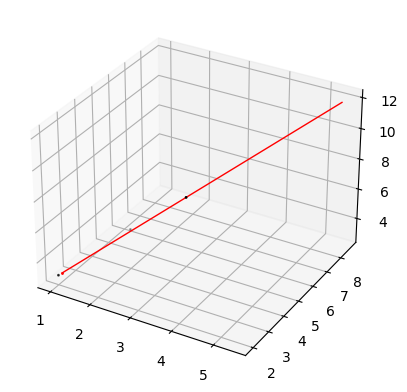

In [9]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter(start[0], start[1], start[2], c = 'red', s = 1)
ax.scatter(points[:,0], points[:, 1], points[:, 2] , c = 'black', s =1)

scale = 6
X_d = [start[0], start[0] + scale* direction_vector[0]]
Y_d = [start[1], start[1] + scale* direction_vector[1]]
Z_d = [start[2], start[2] + scale* direction_vector[2]]

ax.plot(X_d,Y_d,Z_d, color = 'red', linewidth = 1)
            

### Line / Direction vector의 error

In [53]:
# distance between 3 points
error = 0
for k in range(3):
    dist = distance(torch.tensor(start), torch.tensor(points[k]) , torch.tensor(direction_vector))
    error += dist
    print('%d-th point distance'%k,dist)
print('final error:', error/3)

0-th point distance tensor(5.0475e-05)
1-th point distance tensor(0.4151)
2-th point distance tensor(0.0003)
final error: tensor(0.1385)


In [54]:
error = 0
for k in range(3):
    dist = distance(torch.tensor(start, dtype = torch.float32), torch.tensor(points[k]) , torch.tensor(normalized_direction, dtype = torch.float32))
    error += dist
    print('%d-th point distance'%k,dist)
print('final error:', error/3)

0-th point distance tensor(0.0079)
1-th point distance tensor(0.2751)
2-th point distance tensor(0.2594)
final error: tensor(0.1808)


### Interpolation

In [4]:
# 먼저 하나의 order에 대해서 5개의 wavelength를 가지고 25개 wavelength의 coefficient를 찾기
from scipy import interpolate
import torch

In [5]:
param_dir = "../../dataset/image_formation/dat/method2/"

In [6]:
m_list = np.array([-1, 1])
wvl_list = np.arange(450, 660, 50)
depth = np.arange(0.6, 0.9, 0.01)
interpolated_wvls = np.arange(420, 670, 10)
num_param = 21

In [7]:
param_list = np.zeros(shape=(len(m_list), len(wvl_list), len(depth), 21, 2))

In [8]:
# Load datas

for m in range(len(m_list)):
    for w in range(len(wvl_list)):
        for d in range(len(depth)):
            param_list[m, w, d] = param = io.loadmat(os.path.join(param_dir, 'param_dispersion_coordinates_m%d_wvl%d_depth%dcm.mat' %(m_list[m], wvl_list[w], depth[d] * 100)))['p'].T

In [9]:
def cubic_interpolation(x_new, x_points, y_points, n):
    tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
    y_new = interpolate.splev(x_new, tck)
    return y_new

In [10]:
# Interpolation

interpolated_param_list = np.zeros(shape=(len(m_list), len(interpolated_wvls), len(depth), num_param, 2))

# do interpolation
for z in (range(len(depth))):
    for m in (range(len(m_list))):
            for w in (range(len(wvl_list))):
                for i in (range(num_param)):
                    for xy in (range(2)):
                        params = param_list[m,:,z,i,xy]
                        interpolated_param_list[m,:,z,i,xy] = cubic_interpolation(interpolated_wvls, wvl_list, params, 3)

In [11]:
interpolated_param_list.shape

(2, 25, 31, 21, 2)

#### Visualization

In [ ]:
xory = np.array(["x", "y"])
m_str = np.array(["minus1", "plus1"])
for z in (range(len(depth))):
    for m in (range(len(m_list))):
            for i in (range(num_param)):
                for xy in (range(2)):
                    fig = plt.figure()
                    ax = fig.add_subplot(1, 1, 1)
                    plt.title("%s order, %dcm depth, %d-th parameter, %s data" %(m_str[m], depth[z]*100, i, xory[xy]))
                    
                    plt.plot(interpolated_wvls, interpolated_param_list[m,:,z,i,xy], label = 'interpolated data')
                    plt.plot(wvl_list, param_list[m,:,z,i,xy], label = 'prev data')
                    
                    plt.scatter(interpolated_wvls, interpolated_param_list[m,:,z,i,xy], s = 10)
                    plt.scatter(wvl_list, param_list[m,:,z,i,xy], s= 20)
                    
                    ax.set_xticks(interpolated_wvls)
                    ax.set_xlabel("wavelengths(nm)")
                    plt.xticks(rotation = 45)
                    
                    plt.legend()
                    plt.savefig('../../dataset/image_formation/dat/method2/interpolated/visualization/%sorder_%02dcmdepth_%02dparameter_%sdata.png' %(m_str[m], depth[z]*100, i, xory[xy]))
                    plt.show()

#### Reconstruction Test

In [12]:
m_list = np.array([-1, 1])
wvl_list = np.arange(450, 660, 50)
depth = np.arange(0.6, 0.9, 0.01)
interpolated_wvls = np.arange(420, 670, 10)
num_param = 21
dat_path = "../../dataset/image_formation/dat/method2/interpolated"
point_path = "../../dataset/image_formation/dat/method2"
pitch =  7.9559e-06

In [13]:
point = io.loadmat(os.path.join(point_path, 'dispersion_coordinates_m%d_wvl%d_depth%dcm.mat'%(0, 650, 0.72*100)))

In [16]:
def bring_distortion_coeff():
    
    p_list = torch.zeros(size=(len(m_list), len(interpolated_wvls), len(depth), 21, 2))

    # distortion coeff 합치기
    
    for d_i, d in enumerate(depth):
        for m_i, m in enumerate(m_list):
            for wvl_i, wvl in enumerate(interpolated_wvls):
                p = io.loadmat(os.path.join(dat_path, 'param_dispersion_coordinates_m%d_wvl%d_depth%dcm.mat'%(m, wvl,d*100)))
                p = p['p']
                p = torch.tensor(p, dtype=torch.float32)

                p_list[m_i, wvl_i] = p
    
    return p_list

In [17]:
p_list = bring_distortion_coeff()

In [80]:
p_list.shape

torch.Size([2, 25, 31, 21, 2])

In [81]:
def distort_func(x, y, p, q, N = 5): # p = p[:,0], q = p[:,1]

    x = x.unsqueeze(dim = 1).unsqueeze(dim = 1)
    y = y.unsqueeze(dim = 1).unsqueeze(dim = 1)
    
    p = p.unsqueeze(dim = 3)
    q = q.unsqueeze(dim = 3)
    
    print(x.shape, y.shape, p.shape, q.shape)
    
    x_d = p[...,0] + p[...,1]*x + p[...,2]*y + p[...,3]*(x**2) + p[...,4]*x*y + p[...,5]*(y**2) + p[...,6]*(x**3) + p[...,7]*(x**2)*y + p[...,8]*x*(y**2) + p[...,9]*(y**3) + p[...,10]*(x**4) + p[...,11]*(x**3)*y + p[...,12]*(x**2)*(y**2) + p[...,13]*x*(y**3) + p[...,14]*(y**4) + p[...,15]*(x**5) + p[...,16]*(x**4)*y + p[...,17]*(x**3)*(y**2) + p[...,18]*(x**2)*(y**3) + p[...,19]*x*(y**4) + p[...,20]*(y**5)
    y_d = q[...,0] + q[...,1]*x + q[...,2]*y + q[...,3]*(x**2) + q[...,4]*x*y + q[...,5]*(y**2) + q[...,6]*(x**3) + q[...,7]*(x**2)*y + q[...,8]*x*(y**2) + q[...,9]*(y**3) + q[...,10]*(x**4) + q[...,11]*(x**3)*y + q[...,12]*(x**2)*(y**2) + q[...,13]*x*(y**3) + q[...,14]*(y**4) + q[...,15]*(x**5) + q[...,16]*(x**4)*y + q[...,17]*(x**3)*(y**2) + q[...,18]*(x**2)*(y**3) + q[...,19]*x*(y**4) + q[...,20]*(y**5)

    return x_d, y_d

In [82]:
x_point = torch.tensor(point['x']) /pitch
y_point = torch.tensor(point['y']) /pitch
p_list = torch.tensor(p_list)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
x_point.shape

torch.Size([1, 2304])

In [84]:
p_list[...,0].shape

torch.Size([2, 25, 31, 21])

In [85]:
x_d, y_d = distort_func(x_point, y_point, p_list[...,0], p_list[...,1])

torch.Size([1, 1, 1, 2304]) torch.Size([1, 1, 1, 2304]) torch.Size([2, 25, 31, 1, 21]) torch.Size([2, 25, 31, 1, 21])


In [86]:
x_d = x_d.numpy()
y_d = y_d.numpy()

In [87]:
x_d.shape

(2, 25, 31, 2304)

In [ ]:
for m in (range(len(m_list))):
    for z in (range(len(depth))):
            for w in (range(len(interpolated_wvls))):
                    fig = plt.figure()
                    ax = fig.add_subplot(1, 1, 1)
                    plt.title("%d order, %dnm wvl, %dcm depth" %(m_list[m], interpolated_wvls[w], depth[z]*100))
                    plt.scatter(x_d[m,w,z], y_d[m,w,z], s= 10)
                    plt.show()
